# Определение рыночной стоимости недвижиомсти
В распоряжении данные сервиса Яндекс Недвижимость — *архив объявлений о продаже квартир в Санкт-Петербурге и соседних населённых пунктах за несколько лет*. 

Необходимо определить **рыночную стоимость объектов недвижимости**. 

Основная задача — **установить параметр для построения автоматизированной системы**, которая отследит аномалии и мошенническую деятельность.

По каждой квартире на продажу доступны два вида данных. Первые вписаны пользователем, вторые — получены автоматически на основе картографических данных. Например, расстояние до центра, аэропорта, ближайшего парка и водоёма.

### ШАГ 1. Откройте файл с данными и изучите общую информацию. 

In [1]:
import pandas as pd # импорт библиотеки pandas
import matplotlib.pyplot as plt # импортируем библиотеку, стандартно используется имя plt
import numpy as np

In [35]:
try:
    data_original = pd.read_csv('real_estate_data.csv', sep='\t' , decimal='.')
    display(data_original.head())
except:
    data_original = pd.read_csv('/datasets/real_estate_data.csv', sep='\t' , decimal='.')
    display(data_original.head())

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
0,20,13000000.0,108.0,2019-03-07T00:00:00,3,2.70,16.0,51.0,8,NaN,...,25.0,NaN,Санкт-Петербург,18863.0,16028.0,1.0,482.0,2.0,755.0,NaN
1,7,3350000.0,40.4,2018-12-04T00:00:00,1,NaN,11.0,18.6,1,NaN,...,11.0,2.0,посёлок Шушары,12817.0,18603.0,0.0,NaN,0.0,NaN,81.0
2,10,5196000.0,56.0,2015-08-20T00:00:00,2,NaN,5.0,34.3,4,NaN,...,8.3,0.0,Санкт-Петербург,21741.0,13933.0,1.0,90.0,2.0,574.0,558.0
3,0,64900000.0,159.0,2015-07-24T00:00:00,3,NaN,14.0,NaN,9,NaN,...,NaN,0.0,Санкт-Петербург,28098.0,6800.0,2.0,84.0,3.0,234.0,424.0
4,2,10000000.0,100.0,2018-06-19T00:00:00,2,3.03,14.0,32.0,13,NaN,...,41.0,NaN,Санкт-Петербург,31856.0,8098.0,2.0,112.0,1.0,48.0,121.0


В файле в качестве разделителя используется '\\', а разделителем десятичной дроби '.'

Первичный анализ данных:
* По некоторым переменным наблюдаются пропуски в данных
* Для столбца с `first_day_exposition` необходимо изменить тип данных

### ШАГ 2. Предобработка данных.

Рассмотрим общую информацию о данных.

In [36]:
data_original.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23699 entries, 0 to 23698
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   total_images          23699 non-null  int64  
 1   last_price            23699 non-null  float64
 2   total_area            23699 non-null  float64
 3   first_day_exposition  23699 non-null  object 
 4   rooms                 23699 non-null  int64  
 5   ceiling_height        14504 non-null  float64
 6   floors_total          23613 non-null  float64
 7   living_area           21796 non-null  float64
 8   floor                 23699 non-null  int64  
 9   is_apartment          2775 non-null   object 
 10  studio                23699 non-null  bool   
 11  open_plan             23699 non-null  bool   
 12  kitchen_area          21421 non-null  float64
 13  balcony               12180 non-null  float64
 14  locality_name         23650 non-null  object 
 15  airports_nearest   

***ОБЩАЯ ХАРАКТЕРИСТИКА ДАННЫХ***
1) Столбец `total_images` — число фотографий квартиры в объявлении.
* При первичном анализе (при выводе таблицы с данными) проблемы **не выявлены**. 

2) Столбец `last_price` — цена на момент снятия с публикации.
* При первичном анализе (при выводе таблицы с данными) проблемы **не выявлены**. 

3) Столбец `total_area` — площадь квартиры в квадратных метрах (м²).
* При первичном анализе (при выводе таблицы с данными) проблемы **не выявлены**. 

4) Столбец `first_day_exposition` — дата публикации.
* Необходимо **заменить тип данных** на дату и время (время можно убрать, поскольку интересует только дата). 

5) Столбец `rooms` — число комнат.
* При первичном анализе (при выводе таблицы с данными) проблемы **не выявлены**. 

6) Столбец `ceiling_height` — высота потолков (м).
* **Пропуски** в данных требуют дополнительного изучения. 

7) Столбец `floors_total` — всего этажей в доме.
* **Пропуски** в данных требуют дополнительного изучения.
* Необходимо **заменить тип данных** на целое число (дробное число этажей не имеет смысла, хотя я встречал)

8) Столбец `living_area` — жилая площадь в квадратных метрах (м²).
* **Пропуски** в данных требуют дополнительного изучения. 

9) Столбец `floor` — этаж.
* При первичном анализе (при выводе таблицы с данными) проблемы **не выявлены**. 

10) Столбец `is_apartment` — апартаменты (булев тип).
* Необходимо **заменить тип данных** на булевый тип (из описания к данным).
* **Пропуски** в данных требуют дополнительного изучения (кажется логичным заменить пропуски на False).

11) Столбец `studio` — квартира-студия (булев тип).
* При первичном анализе (при выводе таблицы с данными) проблемы **не выявлены**. 

12) Столбец `open_plan` — свободная планировка (булев тип).
* При первичном анализе (при выводе таблицы с данными) проблемы **не выявлены**. 

13) Столбец `kitchen_area` — площадь кухни в квадратных метрах (м²).
* **Пропуски** в данных требуют дополнительного изучения. 

14) Столбец `balcony` — число балконов.
* **Пропуски** в данных требуют дополнительного изучения (кажется логичным заменить пропуски на 0).
* Необходимо **заменить тип данных** на целое число (дробное число балконов не имеет смысла)

15) Столбец `locality_name` — название населённого пункта.
* **Пропуски** в данных требуют дополнительного изучения (вероятно, для анализа данный столбец может не понадобиться и стоит оставить данные как есть) 

16) Столбец `airports_nearest` — расстояние до ближайшего аэропорта в метрах (м).
* **Пропуски** в данных требуют дополнительного изучения. 

17) Столбец `cityCenters_nearest` — расстояние до центра города (м).
* **Пропуски** в данных требуют дополнительного изучения.
* **Переименовать столбец**.

18) Столбец `parks_around3000` — число парков в радиусе 3 км.
* **Пропуски** в данных требуют дополнительного изучения. 

19) Столбец `parks_nearest` — расстояние до ближайшего парка (м).
* **Пропуски** в данных требуют дополнительного изучения. 

20) Столбец `ponds_around3000` — число водоёмов в радиусе 3 км.
* **Пропуски** в данных требуют дополнительного изучения. 

21) Столбец `ponds_nearest` —  расстояние до ближайшего водоёма (м).
* **Пропуски** в данных требуют дополнительного изучения. 

22) Столбец `days_exposition` — days_exposition.
* **Пропуски** в данных требуют дополнительного изучения. 

___________________________________________________________________________
**КРАТКИЙ ВЫВОД**: Выявлены основные 2 проблемы в данных: 1) наличие пропусков; 2) неверный тип данных 

Решение первой проблемы будет зависеть от особенностей столбца. Условно можно выделить ***четыре*** способа решения проблемы в зависимости от особенностей значений в конкретном столбце:
* В некоторых случаях очевидно, какими значениями следует заменить на пропуски.
* В некоторых столбцах замена пропусков может привести к искажению данных, поэтому такие данные оставим без изменений.
* В некоторых столбцах возможно следует ограничиться заменой медианными или средними значениями (в зависимости от распределения значений)
* В некоторых столбцах замену можно производить по общему принципу:
    - Для столбца (обозначим его 'A'), в котором хотим заполнить в пару столбец без пропусков (обозначим его 'B'), который наверняка коррелирует со значениями в столбце с пропусками.
    - Категоризируем данные по столбцу 'B', например на группы (1, 2,..., N в зависимости от переменной посмотрим на распределение).
    - Заполняем пропуски в столбце 'A' медианными или среденими значениями (рассчитанныи для отдельной категории) в соответствии с категорией, к которой относится наблюдение.
___________________________________________________________________________
Несмотря на то, что при выводе таблицы с данными не было выявлено проблем во многих столбцах, следует понимать, что проблемы могут быть скрыты в середине этой таблицы. Поэтому целесообразно написать функцию, которая возвращает набор значений (*включая пропуски*) в отдельно взятом столбце, количество раз, которое встречается каждое значение, и долю этого значения от общего количества наблюдений.

In [37]:
# Создадим новый dataframe (data), куда будем записывать все исправления data_original (исходный файл оставим неизменным)
# чтобы потом была возможность сравнить с исходным набором данных
data = data_original

In [38]:
# переименование столбцов
data = data.rename(columns = {
    'cityCenters_nearest' : 'city_сenters_nearest'
})

In [39]:
# Создаем эту функцию 'unique_values_info'
# Аргументы функции:
# 1) data - данные в формате dataframe
# 2) col_name - название столбца в data, о котором хотим узнать статистику (тип: 'str')

def unique_values_info(data, col_name): # Объявляем функцию
    # Создаем dataframe, в который буудем сохранять статситику по значениям столбца
    # 'count' - количество раз, которое встречается в столбце конкретное значение
    # 'share' - доля количества раз, которое встречается в столбце конкретное значение
    # от общего числа наблюдений (включая пропуски, т. е. пропуски рассматриваем как отдельное значение)
    unique_values_data = pd.DataFrame(columns =['count', 'share'])
    
    # подсчет столбца 'count'
    unique_values_data['count'] = data[col_name].value_counts(dropna=False)
    
    # подсчет столбца 'share'
    unique_values_data['share'] = unique_values_data['count']/unique_values_data['count'].sum()
    
    # На текущем этапе таблица с интересующими данными представляет собой
    # dataframe, в котором индексы соответствуют значениям, которые встречаются 
    # в соответсвующем столбце из исходной таблицы (data).
    # Чтобы создать столбец со значениями, которые встречаются в исходной таблице,
    # необходимо воспользоваться сбросом индексации с сохранением исходной индексации в отдельном столбце,
    # т. е. воспользоваться функцией reset_index(drop=False) (ЕСЛИ НЕПРАВИЛЬНО УПОТРЕБИЛ ТЕРМИН "ФУНКЦИЯ", ТО ПОПРАВЬТЕ!!!)
    # В результате выполнения данной команды по умолчанию создается столбец 'index'.
    # Поскольку данный столбец представляет собой набор уникальных значений в интересующем нас столбце, то
    # целесообразно переименовать его на 'value'
    unique_values_data = unique_values_data.reset_index(drop=False).rename(columns={
    'index': 'value'
})
    # Таким образом, получаем dataframe, в котором отдельная строчка представляет собой
    # уникальное значение из интересующего столбца (столбец'value')
    # количество раз, которое встречается это уникальное значение (столбец'count')
    # доля этого значения в общем количестве наблюдений(столбец'share')
    return display(unique_values_data)

In [40]:
# Создаем эту функцию 'unique_values_info'
# Аргументы функции:
# 1) data - данные в формате dataframe
# 2) col_name - название столбца в data, о котором хотим узнать статистику (тип: 'str')

def value_info_graphics(data, col_name):
    try:
        # считаем квартильный размах
        q1 = data[col_name].describe()['25%']
        q3 = data[col_name].describe()['75%']
        iqr = q3-q1
        
        # ограничиваем график "усами"
        plt.ylim(q1-1.5*iqr, q3+1.5*iqr)
        
        # применяем функцию "unique_values_info"
        unique_values_info(data, col_name)
        
        # выводим диаграмму размаха
        return (data[col_name].describe(), 
                data.boxplot(col_name , showmeans=True),
                print('Левый ус', round(q1-1.5*iqr, 2)),
                print(f'Число выбросов слева: {data[data[col_name]<q1-1.5*iqr][col_name].count()}'),
                print(f'Доля выбросов слева от общей выборки: {data[data[col_name]<q1-1.5*iqr][col_name].count()/data[col_name].shape[0]:.2%}'),
                print(),
                print('Правый ус', round(q3+1.5*iqr, 2)),
                print(f'Число выбросов справа: {data[data[col_name]>q3+1.5*iqr][col_name].count()}'),
                print(f'Доля выбросов справа от общей выборки: {data[data[col_name]>q3+1.5*iqr][col_name].count()/data[col_name].shape[0]:.2%}'),
               )
    except:
        col_type = type(data[col_name][0])
        return (print(f'Описательную статистику НЕЛЬЗЯ ПРЕДСТАВИТЬ для типа данных "{col_type}"!!!'),
                print('СООБЩЕНИЕ НИЖЕ ГОВОРИТ ОБ ОШИБКЕ В БЛОКЕ "TRY", при этом код в этом блоке все равно выполняется!!!'),
                print('ПОЧЕМУ?!'),
                unique_values_info(data, col_name))
    

In [41]:
value_info_graphics(data, 'first_day_exposition')

#меняем тип данных на время и дату
data['first_day_exposition'] = pd.to_datetime(data['first_day_exposition'], format='%Y-%m-%dT%H:%M:%S')

Описательную статистику НЕЛЬЗЯ ПРЕДСТАВИТЬ для типа данных "<class 'str'>"!!!
СООБЩЕНИЕ НИЖЕ ГОВОРИТ ОБ ОШИБКЕ В БЛОКЕ "TRY", при этом код в этом блоке все равно выполняется!!!
ПОЧЕМУ?!


,value,count,share
0,2018-02-01T00:00:00,368,0.015528
1,2017-11-10T00:00:00,240,0.010127
2,2017-10-13T00:00:00,124,0.005232
3,2017-09-27T00:00:00,111,0.004684
4,2018-03-26T00:00:00,97,0.004093
...,...,...,...
1486,2018-05-20T00:00:00,1,0.000042
1487,2015-05-15T00:00:00,1,0.000042
1488,2015-01-12T00:00:00,1,0.000042
1489,2015-12-19T00:00:00,1,0.000042


,value,count,share
0,NaN,9195,0.387991
1,2.50,3515,0.148318
2,2.60,1646,0.069454
3,2.70,1574,0.066416
4,3.00,1112,0.046922
...,...,...,...
179,5.00,1,0.000042
180,2.20,1,0.000042
181,4.15,1,0.000042
182,3.93,1,0.000042


Левый ус 2.1
Число выбросов слева: 14
Доля выбросов слева от общей выборки: 0.06%

Правый ус 3.22
Число выбросов справа: 814
Доля выбросов справа от общей выборки: 3.43%


(count    14504.000000
 mean         2.771499
 std          1.261056
 min          1.000000
 25%          2.520000
 50%          2.650000
 75%          2.800000
 max        100.000000
 Name: ceiling_height, dtype: float64,
 <AxesSubplot:>,
 None,
 None,
 None,
 None,
 None,
 None,
 None)

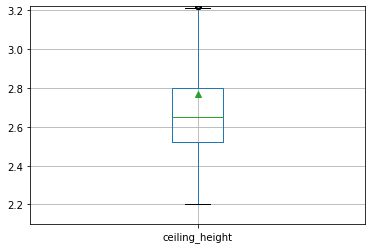

In [42]:
value_info_graphics(data, 'ceiling_height')

#### Выводы по переменной `ceiling_height`:
* Пропуски составляют 38.8%, что довольно много, но данных для заполнения пропусков достаточно.
* Разброс значений очень большой (min = 1 м, max = 100 м). Однако интервал для значений без выбросов от 2.2 м до 3.2 м (не столь значительно), поэтому целесообразно заполнить пропуски средним или медианным значениями.
* Разница между средним и медианными значениями составляет 0.12 м. В абсолютном выражении это незначительно, но, если посмотреть на диаграмму размаха, то можно увидеть, что среднее значение близко к началу 4-ого квартиля (т. е. выбросы справа значительно смещают среднее значение, поэтому стоит заполнить пропуски медианными значениями). Кроме того, медианное значение оказалось кратным 0,1 м, что как правило соответствует проектным документациям при строительстве и люди склонны делать потолки (например натяжные), округляя высоту.

In [43]:
# Заполнение пропусков
data['ceiling_height'] = data['ceiling_height'].fillna(data['ceiling_height'].median())

# Проверка
data['ceiling_height']

0        2.70
1        2.65
2        2.65
3        2.65
4        3.03
         ... 
23694    3.70
23695    2.65
23696    2.65
23697    3.00
23698    2.50
Name: ceiling_height, Length: 23699, dtype: float64

,value,count,share
0,5.0,5788,0.244230
1,9.0,3761,0.158699
2,16.0,1376,0.058062
3,12.0,1362,0.057471
4,4.0,1200,0.050635
5,10.0,1174,0.049538
6,25.0,1075,0.045361
7,6.0,914,0.038567
8,17.0,833,0.035149
9,3.0,668,0.028187


Левый ус -11.5
Число выбросов слева: 0
Доля выбросов слева от общей выборки: 0.00%

Правый ус 32.5
Число выбросов справа: 32
Доля выбросов справа от общей выборки: 0.14%


(count    23613.000000
 mean        10.673824
 std          6.597173
 min          1.000000
 25%          5.000000
 50%          9.000000
 75%         16.000000
 max         60.000000
 Name: floors_total, dtype: float64,
 <AxesSubplot:>,
 None,
 None,
 None,
 None,
 None,
 None,
 None)

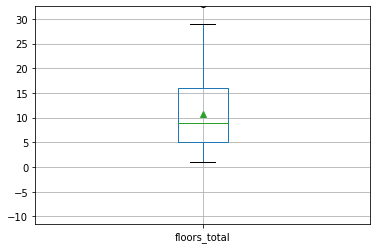

In [44]:
# рассмотри столбец 'floors_total'
value_info_graphics(data, 'floors_total')


#### Выводы по переменной `floors_total`:
* Пропуски составляют 0.36%, что весьма незначительно.
* Разница между средним и медианными значениями составляет 1,7. Если посмотреть на диаграмму размаха, то можно увидеть, что среднее значение близко именно к медиане (т. е. выбросы справа незначительно смещают среднее значение). При заполнении пропусков нужно обратить внимание на моду (наиболее распространенное в выборке значение). Фактически для заполнения пропусков нам доступны три значания: 9 (медиана), 10 (среднее, округленное вниз), 11 (среднее, округленное вверх). Если посмотреть на частоту данных значений, то можно увидеть, что среди этих значений наиболее распространены дома с 9 этажами, 15.9% от всей выборки. А домов в 10 этажей и 11 этажей примерно 5% и 0.9% соответственно. Поэтому заполняем пропуски медианными значениями.
* Изменяем тип на на целочисленный.

In [45]:
# Заполнение пропусков
data['floors_total'] = data['floors_total'].fillna(data['floors_total'].median())

# меняем тип данный
data['floors_total'] = data['floors_total'].astype('int64')

# Проверка
data['floors_total']

0        16
1        11
2         5
3        14
4        14
         ..
23694     5
23695     5
23696     3
23697    17
23698     5
Name: floors_total, Length: 23699, dtype: int64

,value,count,share
0,NaN,1903,0.080299
1,18.00,882,0.037217
2,17.00,675,0.028482
3,30.00,598,0.025233
4,16.00,486,0.020507
...,...,...,...
1778,76.70,1,0.000042
1779,39.41,1,0.000042
1780,124.90,1,0.000042
1781,36.07,1,0.000042


Левый ус -16.95
Число выбросов слева: 0
Доля выбросов слева от общей выборки: 0.00%

Правый ус 77.85
Число выбросов справа: 773
Доля выбросов справа от общей выборки: 3.26%


(count    21796.000000
 mean        34.457852
 std         22.030445
 min          2.000000
 25%         18.600000
 50%         30.000000
 75%         42.300000
 max        409.700000
 Name: living_area, dtype: float64,
 <AxesSubplot:>,
 None,
 None,
 None,
 None,
 None,
 None,
 None)

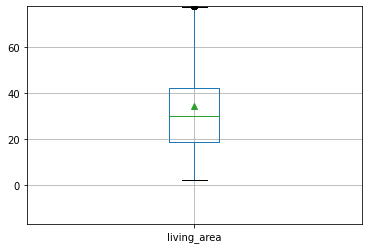

In [46]:
# рассмотри столбец 'living_area'
value_info_graphics(data, 'living_area')

#### Выводы по переменной `living_area`:
* Пропуски составляют 8%, что весьма значительно.
* Разница между средним и медианными значениями составляет примерно 4.5 м². Если посмотреть на диаграмму размаха, то можно увидеть, что среднее значение близко именно к медиане (т. е. выбросы справа незначительно смещают среднее значение).
* однако заполнять пропуски средним и медианными значениями нельзя без дополнительного анализа. Есть предположение, что жилая площадь должна сильно кррелировать с общей площадью (`total_area`). Столбец `total_area` не имеет пропусков, поэтому давайте рассмотрим описательную статистику общей площади для квартир без указания жилой площади.
* Возможно, что данные по жилой площади не указаны там, где свободная планировка, студия или апартаменты. (проверим)

In [47]:
data.loc[data['living_area'].isna(), ['total_area', 'open_plan', 'studio', 'is_apartment']]

# Учитывая, что пропуски в данных столбца 'is_apartment' это вероятно 'False', то можно сказать, 
# что отсутсвие данных по жилой площади не связано с особенностями планировки

,total_area,open_plan,studio,is_apartment
3,159.00,False,False,NaN
7,71.60,False,False,NaN
30,32.80,False,False,NaN
37,45.80,False,False,NaN
44,40.00,False,False,NaN
...,...,...,...,...
23642,80.30,False,False,NaN
23663,88.00,False,False,NaN
23670,45.60,False,False,NaN
23679,35.00,False,False,NaN


,value,count,share
0,42.00,43,0.022596
1,45.00,37,0.019443
2,44.00,35,0.018392
3,31.00,35,0.018392
4,40.00,32,0.016816
...,...,...,...
654,251.00,1,0.000525
655,230.00,1,0.000525
656,280.00,1,0.000525
657,61.62,1,0.000525


Левый ус -4.0
Число выбросов слева: 0
Доля выбросов слева от общей выборки: 0.00%

Правый ус 116.0
Число выбросов справа: 127
Доля выбросов справа от общей выборки: 6.67%


(count    1903.000000
 mean       63.319795
 std        45.070218
 min        13.000000
 25%        41.000000
 50%        53.000000
 75%        71.000000
 max       631.000000
 Name: total_area, dtype: float64,
 <AxesSubplot:>,
 None,
 None,
 None,
 None,
 None,
 None,
 None)

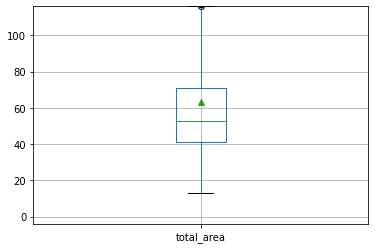

In [48]:
# рассмотрим описательную статистику общей площади для квартир без указания жилой площади.
value_info_graphics(data[data['living_area'].isna()], 'total_area')

#### Выводы по переменной `living_area`:
* Разброс значений общей площади для квартир без указания жилой площади очень большой (тандартное отклонение почти как медиана). Это говорит о том, что заполнять пропуски медианой или средним значениями некорректно.
* Следует посмотреть, насколько жилая площадь коррелирует с общей площадью. Если связь связь сильная, то можно рассчитать отношение жилой площади к общей, посчитать среднюю долю и уже заполнить пропуски в жилой площади путем умножения общей площади на среднюю долю жлой площиди. Тем более данный столбец необходимо посчитать по заданию.

In [49]:
if data['living_area'].corr(data['total_area'])>0.85:
    print('Коэффцициет корреляци общей и жилой площадей равен:', 
          round(data['living_area'].corr(data['total_area']), 2))
    print()
    print('Связь сильная! Будем заполнять пропуски в жилой площади по формуле:')
    print('(ОБЩАЯ ПЛОЩАДЬ)*(СРЕДНЮЮ ДОЛЮ ЖИЛОЙ ПЛОЩАДИ ОТ ОБЩЕЙ ПЛОЩАДИ)')
else:
    print('Коэффцициет корреляци общей и жилой площадей равен:', 
          round(data['living_area'].corr(data['total_area']), 2))
    print()
    print('Связь слабая! ОСТАВЛЯЕМ ПРОПУСКИ!!!')

Коэффцициет корреляци общей и жилой площадей равен: 0.94

Связь сильная! Будем заполнять пропуски в жилой площади по формуле:
(ОБЩАЯ ПЛОЩАДЬ)*(СРЕДНЮЮ ДОЛЮ ЖИЛОЙ ПЛОЩАДИ ОТ ОБЩЕЙ ПЛОЩАДИ)


,value,count,share
0,NaN,1903,0.080299
1,0.500000,341,0.014389
2,0.600000,207,0.008735
3,0.666667,178,0.007511
4,0.562500,116,0.004895
...,...,...,...
11550,0.553421,1,0.000042
11551,0.659898,1,0.000042
11552,0.632931,1,0.000042
11553,0.422662,1,0.000042


Левый ус 0.28
Число выбросов слева: 119
Доля выбросов слева от общей выборки: 0.50%

Правый ус 0.85
Число выбросов справа: 88
Доля выбросов справа от общей выборки: 0.37%


(count    21796.000000
 mean         0.564766
 std          0.105368
 min          0.021583
 25%          0.495177
 50%          0.567860
 75%          0.637880
 max          1.000000
 Name: living_area_ratio, dtype: float64,
 <AxesSubplot:>,
 None,
 None,
 None,
 None,
 None,
 None,
 None)

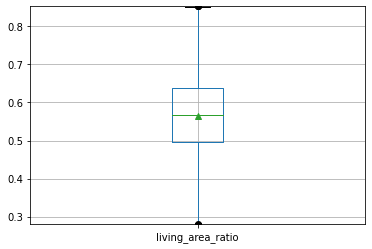

In [50]:
# Считаемдолю жилой площади от общей
data['living_area_ratio'] = data['living_area']/data['total_area']
value_info_graphics(data, 'living_area_ratio')

* Среднее и медианные значения практически совпали Это указывает на то, что доля жилой площади
* Рассмотрим гистограмму для доли жилой площади

(0.0, 1200.0)

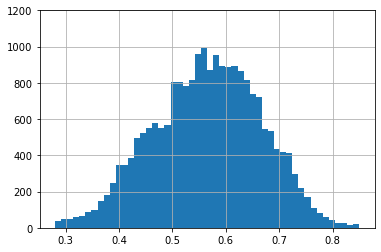

In [51]:
# Очень похоже на нормальное распределение
data['living_area_ratio'].hist(bins=50, range=(0.28, 0.85))
plt.ylim(0, 1200)

In [52]:
data['living_area_ratio']

0        0.472222
1        0.460396
2        0.612500
3             NaN
4        0.320000
           ...   
23694    0.547792
23695    0.644068
23696    0.523810
23697         NaN
23698    0.380805
Name: living_area_ratio, Length: 23699, dtype: float64

In [53]:
# Заполним пропуски в жилой площиди с помощью средней доли
data['living_area'] = data['living_area'].fillna(data['total_area']*(data['living_area_ratio'].mean()))

# обновим данные в 'living_area_ratio', поскольку там были пропуски
data['living_area_ratio'] = data['living_area']/data['total_area']

# проверка
display(data[['total_area','living_area','living_area_ratio']])

,total_area,living_area,living_area_ratio
0,108.00,51.000000,0.472222
1,40.40,18.600000,0.460396
2,56.00,34.300000,0.612500
3,159.00,89.797718,0.564766
4,100.00,32.000000,0.320000
...,...,...,...
23694,133.81,73.300000,0.547792
23695,59.00,38.000000,0.644068
23696,56.70,29.700000,0.523810
23697,76.75,43.345754,0.564766


In [54]:
# Рассмотрим столбец 'is_apartment'
value_info_graphics(data, 'is_apartment')

Описательную статистику НЕЛЬЗЯ ПРЕДСТАВИТЬ для типа данных "<class 'float'>"!!!
СООБЩЕНИЕ НИЖЕ ГОВОРИТ ОБ ОШИБКЕ В БЛОКЕ "TRY", при этом код в этом блоке все равно выполняется!!!
ПОЧЕМУ?!


,value,count,share
0,NaN,20924,0.882906
1,False,2725,0.114984
2,True,50,0.002110


(None, None, None, None)

#### Выводы по переменной `is_apartment`:
* Пропусков в столбце БОЛЕЕ 88%. Наверняка, пропуски соответствуют именно квартирам, а не аппартаментам. Поэтому целесообразно заполнить их значениями 'False'

In [55]:
data['is_apartment'] = data['is_apartment'].fillna(False)
data['is_apartment']

0        False
1        False
2        False
3        False
4        False
         ...  
23694    False
23695    False
23696    False
23697    False
23698    False
Name: is_apartment, Length: 23699, dtype: bool

,value,count,share
0,NaN,2278,0.096122
1,6.00,1300,0.054855
2,10.00,1262,0.053251
3,8.00,1110,0.046837
4,9.00,1101,0.046458
...,...,...,...
967,53.10,1,0.000042
968,12.56,1,0.000042
969,11.84,1,0.000042
970,13.27,1,0.000042


Левый ус -0.5
Число выбросов слева: 0
Доля выбросов слева от общей выборки: 0.00%

Правый ус 19.5
Число выбросов справа: 1190
Доля выбросов справа от общей выборки: 5.02%


(count    21421.000000
 mean        10.569807
 std          5.905438
 min          1.300000
 25%          7.000000
 50%          9.100000
 75%         12.000000
 max        112.000000
 Name: kitchen_area, dtype: float64,
 <AxesSubplot:>,
 None,
 None,
 None,
 None,
 None,
 None,
 None)

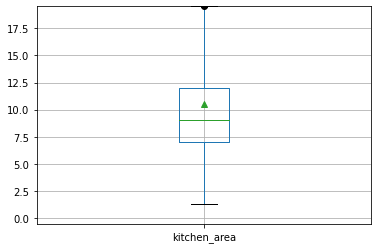

In [56]:
# рассмотри столбец 'living_area'
value_info_graphics(data, 'kitchen_area')

#### Выводы по переменной `kitchen_area`:
* Пропуски составляют 9.6%, что весьма значительно.
* Разница между средним и медианными значениями составляет примерно 1.5 м². Если посмотреть на диаграмму размаха, то можно увидеть, что среднее значение близко именно к медиане (т. е. выбросы справа незначительно смещают среднее значение).
* Однако заполнять пропуски средним и медианными значениями нельзя без дополнительного анализа. Есть предположение, что площадь кухни должна сильно кррелировать с общей площадью (`total_area`). Столбец `total_area` не имеет пропусков, поэтому давайте рассмотрим описательную статистику общей площади для квартир без указания жилой площади.
* 

,value,count,share
0,31.0,47,0.020632
1,42.0,43,0.018876
2,45.0,43,0.018876
3,40.0,33,0.014486
4,25.0,33,0.014486
...,...,...,...
717,45.4,1,0.000439
718,20.6,1,0.000439
719,251.0,1,0.000439
720,71.8,1,0.000439


Левый ус -12.09
Число выбросов слева: 0
Доля выбросов слева от общей выборки: 0.00%

Правый ус 110.81
Число выбросов справа: 125
Доля выбросов справа от общей выборки: 5.49%


(count    2278.000000
 mean       56.575680
 std        40.863558
 min        12.000000
 25%        34.000000
 50%        46.000000
 75%        64.725000
 max       500.000000
 Name: total_area, dtype: float64,
 <AxesSubplot:>,
 None,
 None,
 None,
 None,
 None,
 None,
 None)

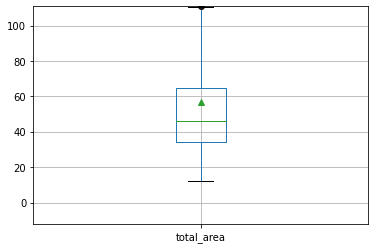

In [57]:
# рассмотрим описательную статистику общей площади для квартир без указания жилой площади.
value_info_graphics(data[data['kitchen_area'].isna()], 'total_area')

#### Выводы по переменной `kitchen_area`:
* Разброс значений общей площади для квартир без указания площади кухни очень большой (стандартное отклонение почти как медиана). Это говорит о том, что заполнять пропуски медианой или средним значениями некорректно.
* Следует посмотреть, насколько жилая площадь коррелирует с общей площадью. Если связь связь сильная, то можно рассчитать отношение жилой площади к общей, посчитать среднюю долю и уже заполнить пропуски в жилой площади путем умножения общей площади на среднюю долю жлой площиди. Тем более данный столбец необходимо посчитать по заданию.
* Возможно, что данные по жилой площади не указаны там, где свободная планировка, студия или апартаменты. (проверим)

In [58]:
data.loc[data['kitchen_area'].isna(), ['total_area', 'open_plan', 'studio', 'is_apartment']]

# Jтсутсвие данных по площади кухни не связано с особенностями планировки и типом самого помещения

,total_area,open_plan,studio,is_apartment
3,159.0,False,False,False
30,32.8,False,False,False
37,45.8,False,False,False
44,40.0,False,False,False
59,46.5,False,False,False
...,...,...,...,...
23655,40.5,False,False,False
23663,88.0,False,False,False
23670,45.6,False,False,False
23679,35.0,False,False,False


In [59]:
if data['kitchen_area'].corr(data['total_area'])>0.85:
    print('Коэффцициет корреляци общей площадью и площадью кухни равен:', 
          round(data['kitchen_area'].corr(data['total_area']), 2))
    print()
    print('Связь сильная! Будем заполнять пропуски в площади кухни по формуле:')
    print('(ОБЩАЯ ПЛОЩАДЬ)*(СРЕДНЮЮ ДОЛЮ ПЛОЩАДИ КУХНИ ОТ ОБЩЕЙ ПЛОЩАДИ)')
else:
    print('Коэффцициет корреляци общей площадью и площадью кухни равен:', 
          round(data['kitchen_area'].corr(data['total_area']), 2))
    print()
    print('Связь слабая! ПРОПУСКИ НЕ ЗАПОЛНЯЕМ. НУЖНО УТОЧНИТЬ ПРИЧИНУ ПРОПУСКОВ!')

Коэффцициет корреляци общей площадью и площадью кухни равен: 0.61

Связь слабая! ПРОПУСКИ НЕ ЗАПОЛНЯЕМ. НУЖНО УТОЧНИТЬ ПРИЧИНУ ПРОПУСКОВ!


,value,count,share
0,NaN,11519,0.486054
1,1.0,4195,0.177012
2,0.0,3758,0.158572
3,2.0,3659,0.154395
4,5.0,304,0.012828
5,4.0,183,0.007722
6,3.0,81,0.003418


Левый ус -3.0
Число выбросов слева: 0
Доля выбросов слева от общей выборки: 0.00%

Правый ус 5.0
Число выбросов справа: 0
Доля выбросов справа от общей выборки: 0.00%


(count    12180.000000
 mean         1.150082
 std          1.071300
 min          0.000000
 25%          0.000000
 50%          1.000000
 75%          2.000000
 max          5.000000
 Name: balcony, dtype: float64,
 <AxesSubplot:>,
 None,
 None,
 None,
 None,
 None,
 None,
 None)

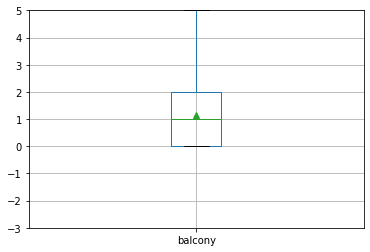

In [60]:
value_info_graphics(data, 'balcony')

In [61]:
# Заменяем пропуски по смыслу 0 и меняем тип данных.
data['balcony'] = data['balcony'].fillna(0).astype('int64')

# проверка

data['balcony']

0        0
1        2
2        0
3        0
4        0
        ..
23694    0
23695    0
23696    0
23697    2
23698    0
Name: balcony, Length: 23699, dtype: int64

* Заполнить пропуски в данных, касающихся расположения дома относительно других объектов (центра города, водоемов, аэропорта), не представляется возможным. Разве что приблизительно поиском близнецов, т. е. квартиры из того же района но с заполненными данными по инфраструктуре. Однако районы бывают также большими и точность такого метода может быть ограничена км, а не м. Пропуски можно объяснить ошибками в сборе и выгрузки данных.
* Однако следует заметить, что возможна ситуация не согласованности данных. Например, в столбце 'park_nearest' будет значение 2000, а при этом в переменной 'park_around3000' будет 0. Это может указывать на недостоверность данных в одном или другом столбце.
* В переменной 'days_exposition' пропуски вероятно означают, что объявление до сих пор не снято. 

#### КРАТКИЙ ВЫВОД ПО ПРЕДОБРАБОТКЕ ДАННЫХ

* Были выявлены проблемы в данных: пропуски и несоотвтествие типов.
* Для некоторых столбцов удалось заполнить пропуски средними или медианными значениями
* Для прочих столбцов заполнение пропусков не представлялось целесообразным
* Возможно, что в процессе дальнейшего анализа будет найден подходящий способ заполнения отсавшихся пропусков

### ШАГ  3. Посчитать и добавьте в таблицу новые переменные

* Цена квадратного метра
* День недели, месяц и год публикации объявления;
* Этаж квартиры; варианты — первый, последний, другой;
* Соотношение жилой и общей площади, а также отношение площади кухни к общей.

In [62]:
# Цена квадратного метра
data['m_2_price'] = data['last_price']/data['total_area']

# проверка
data['m_2_price']

0        120370.370370
1         82920.792079
2         92785.714286
3        408176.100629
4        100000.000000
             ...      
23694     72490.845228
23695     52542.372881
23696     44091.710758
23697    149511.400651
23698     41795.665635
Name: m_2_price, Length: 23699, dtype: float64

In [63]:
# День недели публикации объявления
data['weekday_exposition'] = data['first_day_exposition'].dt.weekday+1

# Месяц публикации объявления
data['month_exposition'] = data['first_day_exposition'].dt.month

# Год публикации объявления
data['year_exposition'] = data['first_day_exposition'].dt.year

# Проверка
display(data[['weekday_exposition', 'month_exposition', 'year_exposition']])

,weekday_exposition,month_exposition,year_exposition
0,4,3,2019
1,2,12,2018
2,4,8,2015
3,5,7,2015
4,2,6,2018
...,...,...,...
23694,2,3,2017
23695,1,1,2018
23696,7,2,2018
23697,2,3,2017


In [64]:
# категоризация этажа
data['floor_category'] = np.where(data['floor']==data['floors_total'], 'последний',
                                 np.where(data['floor']==1, 'первый', 'другой')
                                 )

# проверка
data['floor_category'].value_counts()

другой       17441
последний     3366
первый        2892
Name: floor_category, dtype: int64

In [65]:
# Соотношение жилой и общей площади уже посчитано в разделе предобработке данных!!!

# Соотношение площади кухни к общей
data['kitchen_area_ratio'] = data['kitchen_area']/data['total_area']

# проверка
data['kitchen_area_ratio']

0        0.231481
1        0.272277
2        0.148214
3             NaN
4        0.410000
           ...   
23694    0.103356
23695    0.144068
23696         NaN
23697    0.303583
23698    0.278638
Name: kitchen_area_ratio, Length: 23699, dtype: float64

### Шаг 4. Провести исследовательский анализ данных и выполнить инструкции

* Изучите следующие параметры: площадь, цена, число комнат, высота потолков. Постройте гистограммы для каждого параметра.

* Изучите время продажи квартиры. Постройте гистограмму. Посчитайте среднее и медиану. Опишите, сколько обычно занимает продажа. Когда можно считать, что продажи прошли очень быстро, а когда необычно долго?

* Уберите редкие и выбивающиеся значения. Опишите, какие особенности обнаружили.
* Какие факторы больше всего влияют на стоимость квартиры? Изучите, зависит ли цена от площади, числа комнат, удалённости от центра. Изучите зависимость цены от того, на каком этаже расположена квартира: первом, последнем или другом. Также изучите зависимость от даты размещения: дня недели, месяца и года.

* Выберите 10 населённых пунктов с наибольшим числом объявлений. Посчитайте среднюю цену квадратного метра в этих населённых пунктах. Выделите среди них населённые пункты с самой высокой и низкой стоимостью жилья. Эти данные можно найти по имени в столбце `locality_name`.

* Изучите предложения квартир: для каждой квартиры есть информация о расстоянии до центра. Выделите квартиры в Санкт-Петербурге (`locality_name`). Ваша задача — выяснить, какая область входит в центр. Создайте столбец с расстоянием до центра в километрах: округлите до целых значений. После этого посчитайте среднюю цену для каждого километра. Постройте график: он должен показывать, как цена зависит от удалённости от центра. Определите границу, где график сильно меняется, — это и будет центральная зона.

* Выделите сегмент квартир в центре. Проанализируйте эту территорию и изучите следующие параметры: площадь, цена, число комнат, высота потолков. Также выделите факторы, которые влияют на стоимость квартиры (число комнат, этаж, удалённость от центра, дата размещения объявления). Сделайте выводы. Отличаются ли они от общих выводов по всей базе?

#### Изучите следующие параметры: площадь, цена, число комнат, высота потолков. Постройте гистограммы для каждого параметра.

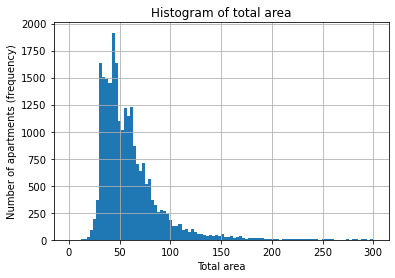

count    23699.000000
mean        60.348651
std         35.654083
min         12.000000
25%         40.000000
50%         52.000000
75%         69.900000
max        900.000000
Name: total_area, dtype: float64

In [66]:
data['total_area'].hist(bins=100, range = (0,300))

plt.title('Histogram of total area')
plt.xlabel('Total area')
plt.ylabel("Number of apartments (frequency)")

plt.show()

data['total_area'].describe()

# Скошенность враво распределения.
# Наибольшее число квартир имеет площадь в диапазоне 35-50 кв. м.

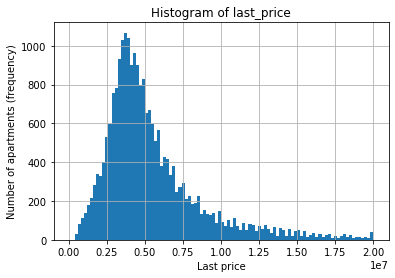

count    2.369900e+04
mean     6.541549e+06
std      1.088701e+07
min      1.219000e+04
25%      3.400000e+06
50%      4.650000e+06
75%      6.800000e+06
max      7.630000e+08
Name: last_price, dtype: float64

In [67]:
data['last_price'].hist(bins=100, range = (0,20000000))

plt.title('Histogram of last_price')
plt.xlabel('Last price')
plt.ylabel("Number of apartments (frequency)")
plt.show()
data['last_price'].describe()

# Скошенность враво распределения.
# Наибольшее число квартир имеет стоимость 2,5 - 5,0 млн рублей.

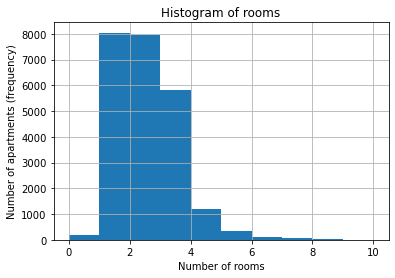

count    23699.000000
mean         2.070636
std          1.078405
min          0.000000
25%          1.000000
50%          2.000000
75%          3.000000
max         19.000000
Name: rooms, dtype: float64

In [68]:
data['rooms'].hist(bins=10, range = (0, 10))

plt.title('Histogram of rooms')
plt.xlabel('Number of rooms')
plt.ylabel("Number of apartments (frequency)")

plt.show()
data['rooms'].describe()

# Скошенность враво распределения.
# Наибольшее число квартир имеет 1 или 2 комнаты.

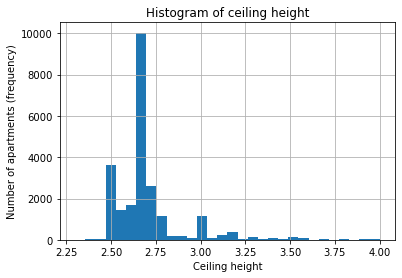

count    23699.000000
mean         2.724358
std          0.988298
min          1.000000
25%          2.600000
50%          2.650000
75%          2.700000
max        100.000000
Name: ceiling_height, dtype: float64

In [69]:
data['ceiling_height'].hist(bins=30, range = (2.3, 4))

plt.title('Histogram of ceiling height')
plt.xlabel('Ceiling height')
plt.ylabel("Number of apartments (frequency)")

plt.show()
data['ceiling_height'].describe()

# Скошенность враво распределения.
# Наибольшее число квартир имеет высоту потолков 2,5 - 2,7 м 
# (это с учетом того, что мы заменили пропуски на медианное значение 2,65 м)

#### Изучите время продажи квартиры. Постройте гистограмму. Посчитайте среднее и медиану. Опишите, сколько обычно занимает продажа. Когда можно считать, что продажи прошли очень быстро, а когда необычно долго?

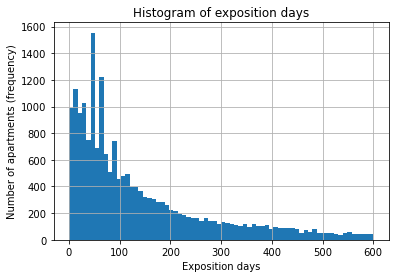

count    20518.000000
mean       180.888634
std        219.727988
min          1.000000
25%         45.000000
50%         95.000000
75%        232.000000
max       1580.000000
Name: days_exposition, dtype: float64

In [70]:
data['days_exposition'].hist(bins=70, range=(0,600))

plt.title('Histogram of exposition days')
plt.xlabel('Exposition days')
plt.ylabel("Number of apartments (frequency)")

plt.show()
data['days_exposition'].describe()

# Распределение Пуассона (события в единицу времени)
# Среднее равно 180 дней.
# Медиана равна 95 дней.

# В данном случае дольше обычного может считаться прадажа квартиры через 95 дней и более. 
# Все, что меньше можно считать быстрой продажей

In [71]:
# # КОД РЕВЬЮЕРА
def quartile_range(df, column):
     q1 = df[column].quantile(0.25)
     q3 = df[column].quantile(0.75)
     iqr = q3 - q1
     dfq = df.loc[(df[column] < q3 + 1.5*iqr) & (df[column] > q1 - 1.5*iqr), column]
     return dfq

list_features = ['last_price', 'total_area', 'kitchen_area', 'living_area', 'days_exposition', 'ceiling_height', 'rooms']
for col in list_features:
    data[col] = quartile_range(data, col)    

In [72]:
def delete_anomalies(data, col_name):
    q1=data[col_name].describe()['25%']
    q3=data[col_name].describe()['75%']
    iqr=q3-q1
    lower_bound = q1-1.5*iqr
    upper_bound = q3+1.5*iqr
    
    no_anomalies_condition = ((data[col_name]>=lower_bound) == (data[col_name]<=upper_bound))
    
    data = data[no_anomalies_condition] #УДАЛЯЮ ВЫБРОСЫ, НО ЭТА СТРОЧКА СЛОВНО НЕ РАБОТАЕТ. ОБЪЯСНИТЕ, ПОЖАЛУЙСТА

    return data

In [73]:
def anomalies_count(data, col_name):
    q1=data[col_name].describe()['25%']
    q3=data[col_name].describe()['75%']
    iqr=q3-q1
    lower_bound = q1-1.5*iqr
    upper_bound = q3+1.5*iqr
    
    no_anomalies_condition = ((data[col_name]>=lower_bound) == (data[col_name]<=upper_bound))
    return (data.shape[0]-no_anomalies_condition.sum())

In [74]:
col_list = ['total_area', 'last_price', 'rooms', 'ceiling_height', 'days_exposition']
for col_name in col_list:
    print(f'В столбце "{col_name}" удалено {anomalies_count(data, col_name)} штук аномальных наблюдений.')
    print(f'Осталось наблюдений {data.shape[0]-anomalies_count(data, col_name)}')
    data = delete_anomalies(data, col_name)

В столбце "total_area" удалено 400 штук аномальных наблюдений.
Осталось наблюдений 23299
В столбце "last_price" удалено 709 штук аномальных наблюдений.
Осталось наблюдений 22590
В столбце "rooms" удалено 0 штук аномальных наблюдений.
Осталось наблюдений 22590
В столбце "ceiling_height" удалено 1222 штук аномальных наблюдений.
Осталось наблюдений 21368
В столбце "days_exposition" удалено 953 штук аномальных наблюдений.
Осталось наблюдений 20415


In [75]:
data

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,ponds_around3000,ponds_nearest,days_exposition,living_area_ratio,m_2_price,weekday_exposition,month_exposition,year_exposition,floor_category,kitchen_area_ratio
1,7,3350000.0,40.4,2018-12-04,1.0,2.65,11,18.600000,1,False,...,0.0,NaN,81.0,0.460396,82920.792079,2,12,2018,первый,0.272277
2,10,5196000.0,56.0,2015-08-20,2.0,2.65,5,34.300000,4,False,...,2.0,574.0,NaN,0.612500,92785.714286,4,8,2015,другой,0.148214
5,10,2890000.0,30.4,2018-09-10,1.0,2.65,12,14.400000,5,False,...,NaN,NaN,55.0,0.473684,95065.789474,1,9,2018,другой,0.299342
6,6,3700000.0,37.3,2017-11-02,1.0,2.65,26,10.600000,6,False,...,0.0,NaN,155.0,0.284182,99195.710456,4,11,2017,другой,0.386059
7,5,7915000.0,71.6,2019-04-18,2.0,2.65,24,40.437211,22,False,...,0.0,NaN,NaN,0.564766,110544.692737,4,4,2019,другой,0.263966
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23693,9,4600000.0,62.4,2016-08-05,3.0,2.60,9,40.000000,8,False,...,1.0,675.0,239.0,0.641026,73717.948718,5,8,2016,другой,0.128205
23694,9,9700000.0,NaN,2017-03-21,3.0,NaN,5,73.300000,3,False,...,3.0,381.0,NaN,0.547792,72490.845228,2,3,2017,другой,0.103356
23695,14,3100000.0,59.0,2018-01-15,3.0,2.65,5,38.000000,4,False,...,NaN,NaN,45.0,0.644068,52542.372881,1,1,2018,другой,0.144068
23696,18,2500000.0,56.7,2018-02-11,2.0,2.65,3,29.700000,1,False,...,NaN,NaN,NaN,0.523810,44091.710758,7,2,2018,первый,NaN


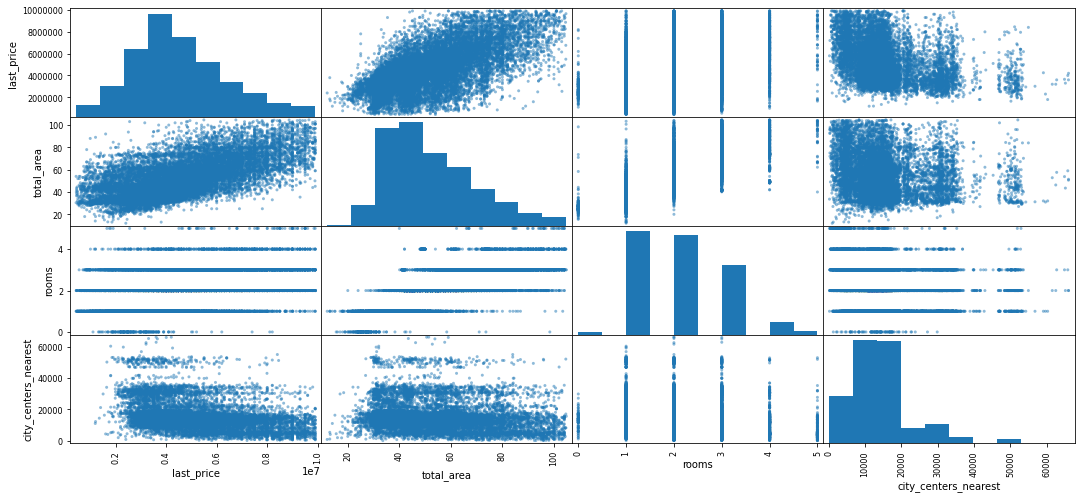

                      last_price  total_area     rooms  city_сenters_nearest
last_price              1.000000    0.652349  0.424539             -0.328576
total_area              0.652349    1.000000  0.793999             -0.136815
rooms                   0.424539    0.793999  1.000000             -0.137979
city_сenters_nearest   -0.328576   -0.136815 -0.137979              1.000000


In [76]:
pd.plotting.scatter_matrix(data[['last_price', 'total_area', 'rooms', 'city_сenters_nearest']], figsize=(18, 8))
plt.show()
print(data[['last_price', 'total_area', 'rooms', 'city_сenters_nearest']].corr())

* Цена положительно зависит от площади
* Цена положительно зависит от числа комнат
* Цена отрицательно зависит от расстояния до центра
* В целом знаки коэффициентов коррелиций совпадают с ожиданиями, но при этом степень влияния у всех этих показателей незначительная (ни один из коэффициентов корелеции не достиг значений 0.8)

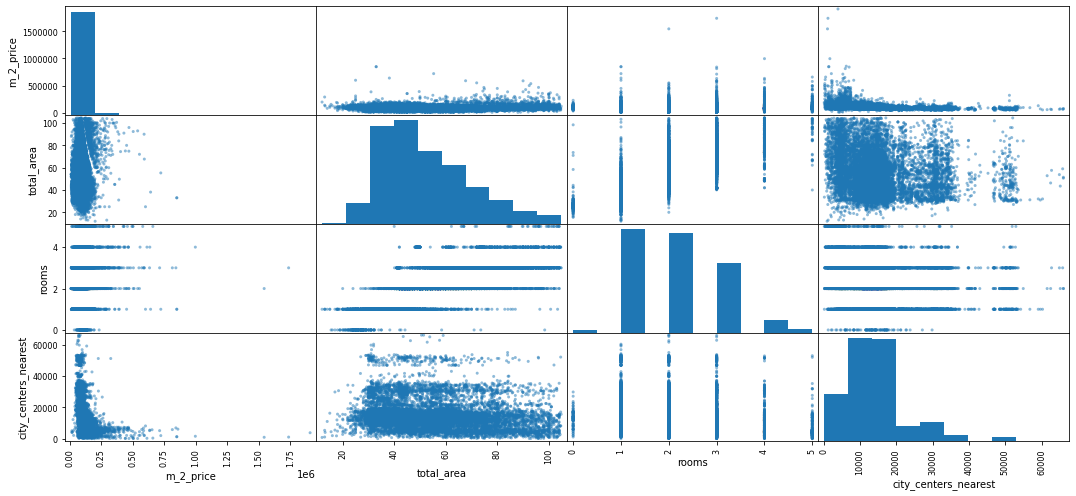

                      m_2_price  total_area     rooms  city_сenters_nearest
m_2_price              1.000000    0.041500  0.006637             -0.314438
total_area             0.041500    1.000000  0.793999             -0.136815
rooms                  0.006637    0.793999  1.000000             -0.137979
city_сenters_nearest  -0.314438   -0.136815 -0.137979              1.000000


In [77]:
pd.plotting.scatter_matrix(data[['m_2_price', 'total_area', 'rooms', 'city_сenters_nearest']], figsize=(18, 8))
plt.show()
print(data[['m_2_price', 'total_area', 'rooms', 'city_сenters_nearest']].corr())

* Цена кв. м положительно зависит от площади
* Цена кв. м положительно зависит от числа комнат
* Цена кв. м отрицательно зависит от расстояния до центра
* В целом знаки коэффициентов коррелиций совпадают с ожиданиями, но при этом степень влияния у всех этих показателей незначительная (ни один из коэффициентов корелеции не достиг значений 0.8)

<AxesSubplot:xlabel='floor_category'>

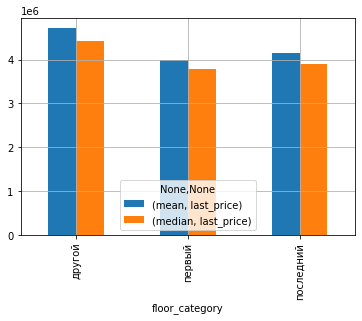

In [78]:
floor_pivot = data.pivot_table(index='floor_category', values='last_price', aggfunc= ['mean', 'median'])
floor_pivot.plot(kind='bar', grid= True)

* Если смотреть на среднюю стоимость, то влияние этажа очевидно.
* Однако по медианному значению цены, аказывается, что любой другой этаж дороже последнего. Возможно это связано с тем, другой этаж - это слишком широкая категория. Возможна ситуация, кода другой этаж будет в одном добе выше, чем последний.

<AxesSubplot:xlabel='floor_category'>

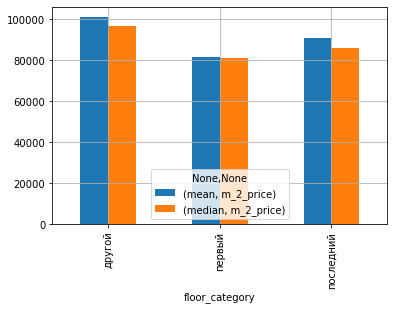

In [79]:
floor_pivot_m2 = data.pivot_table(index='floor_category', values='m_2_price', aggfunc= ['mean', 'median'])
floor_pivot_m2.plot(kind='bar', grid= True)

Аналогично и для цены за квадратный метр

<AxesSubplot:xlabel='weekday_exposition'>

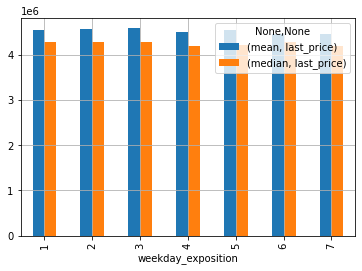

In [80]:
weekday_exposition = data.pivot_table(index='weekday_exposition', values='last_price', aggfunc= ['mean', 'median'])
weekday_exposition.plot(kind='bar', grid= True)

<AxesSubplot:xlabel='weekday_exposition'>

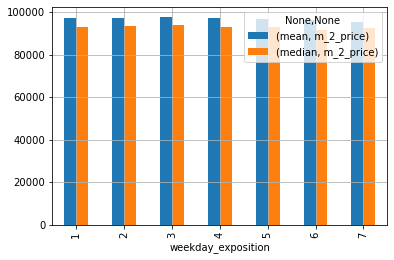

In [81]:
weekday_exposition_m2 = data.pivot_table(index='weekday_exposition', values='m_2_price', aggfunc= ['mean', 'median'])
weekday_exposition_m2.plot(kind='bar', grid= True)

День недели, когда выставили квартиру на продажу, не оказывает никакого влияния на цену квартир и цену кв. м жилья.

<AxesSubplot:xlabel='month_exposition'>

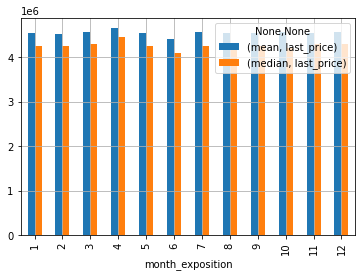

In [82]:
month_exposition = data.pivot_table(index='month_exposition', values='last_price', aggfunc= ['mean', 'median'])
month_exposition.plot(kind='bar', grid= True)

<AxesSubplot:xlabel='month_exposition'>

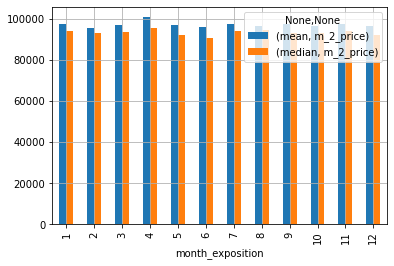

In [83]:
month_exposition_m2 = data.pivot_table(index='month_exposition', values='m_2_price', aggfunc= ['mean', 'median'])
month_exposition_m2.plot(kind='bar', grid= True)

Месяц, когда выставили квартиру на продажу, не оказывает никакого влияния на цену квартир и цену кв. м жилья.

In [84]:
year_exposition = data.pivot_table(index='year_exposition', 
                                   values=['last_price', 'total_area'], 
                                   aggfunc= ['count', 'mean', 'median'])

year_exposition

count                     mean                median  \
                last_price total_area    last_price total_area last_price   
year_exposition                                                             
2014                    78         92  5.229259e+06  63.703478  5120000.0   
2015                   727        760  4.860773e+06  57.053526  4700000.0   
2016                  2058       2111  4.528226e+06  52.836116  4165000.0   
2017                  6438       6602  4.464908e+06  52.116242  4115000.0   
2018                  7193       7380  4.488100e+06  51.477153  4220000.0   
2019                  2373       2468  4.832459e+06  52.059194  4650000.0   

                            
                total_area  
year_exposition             
2014                  61.3  
2015                  56.0  
2016                  49.0  
2017                  48.0  
2018                  48.0  
2019                  49.2

Изначально если смотреть на среднюю стоимость квартиры, то мы получаем контринтуитивный вывод, что самая высокая цена была в самыом раннем году. Хотя если мы считаем, что цены даны в номинальном (не очищенном от инфляции) выражении, то стоило ожидать роста цены. Если добавить среднюю площадь, продаваемых квартир то окажется, что большая цена квартир в ранние годы объясняется, тем, что значительно снижалась средняя площадь квартир. К тому же число продаваемых квартир по годам сильно увеличивалось (кроме 2019 г. возможно данные не за весь год). Возможно, что когда только появлялась возможность продавать квартиру через данную платформу, туда выкладывали более дорогие квартиры.

In [85]:
data.pivot_table(index='year_exposition', values=['m_2_price', 'total_area'], aggfunc= ['mean', 'median'])

mean                    median           
                     m_2_price total_area      m_2_price total_area
year_exposition                                                    
2014             125248.741080  63.703478  106406.451872       61.3
2015             101698.827147  57.053526   91519.328738       56.0
2016              96224.417626  52.836116   90822.179732       49.0
2017              95156.412295  52.116242   90533.270443       48.0
2018              95315.045858  51.477153   94125.150060       48.0
2019             104891.207702  52.059194  101460.484957       49.2

Если же посмотреть на цену за квадратный метр жилья, то разры в средней стоимости не столь велик. 

Выберем 10 населённых пунктов с наибольшим числом объявлений. Посчитаем среднюю цену квадратного метра в этих населённых пунктах. Выделим среди них населённые пункты с самой высокой и низкой стоимостью жилья. 

<AxesSubplot:xlabel='locality_name'>

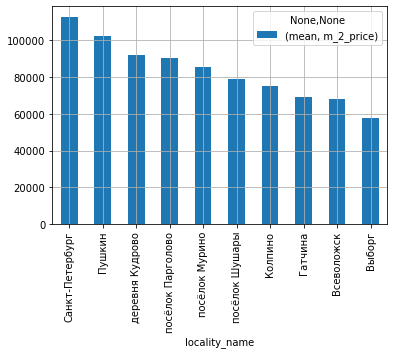

In [86]:
# Создаем таблицу по принципу бритвы Окамы
d = data.pivot_table(index='locality_name', 
                 values='m_2_price', 
                 aggfunc= ['mean', 'count']).sort_values(by=[('count', 'm_2_price')], 
                                                         ascending=False).head(10).sort_values(by=[('mean', 'm_2_price')], 
                                                                                               ascending=False)
d.plot(y = ('mean', 'm_2_price'), kind='bar', grid= True)

<AxesSubplot:xlabel='locality_name'>

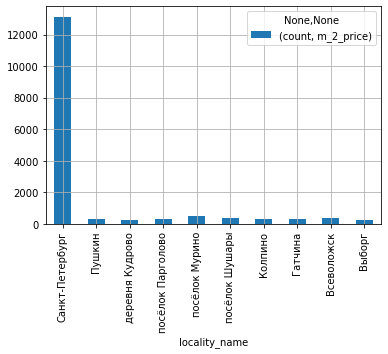

In [87]:
d.plot(y = ('count', 'm_2_price'), kind='bar', grid= True)

Изучим предложения квартир: для каждой квартиры есть информация о расстоянии до центра. Выделим квартиры в Санкт-Петербурге (locality_name). Задача — выяснить, какая область входит в центр. Создадим столбец с расстоянием до центра в километрах: округлим до целых значений. После этого посчитаем среднюю цену для каждого километра. Построим график: он должен показывать, как цена зависит от удалённости от центра. Определим границу, где график сильно меняется, — это и будет центральная зона.

In [88]:
# Переводим расстояние до центра в км
data['center_distance_km'] = round(data['city_сenters_nearest']/1000, 0)

# заполняем пропуски -1
data['center_distance_km'] = data['center_distance_km'].fillna(-1).astype('int64')

# проверка
data['center_distance_km']

1        19
2        14
5        -1
6        19
7        12
         ..
23693    34
23694     4
23695    -1
23696    -1
23698    -1
Name: center_distance_km, Length: 20415, dtype: int64

In [89]:
spb_data = data[data['locality_name']=='Санкт-Петербург']
spb_pivot_data = spb_data.pivot_table(index='center_distance_km', 
                     values='m_2_price', 
                     aggfunc= ['mean']).reset_index(drop=False)

spb_pivot_data

,center_distance_km,mean
,,m_2_price
0,-1,144944.998547
1,0,291335.466112
2,1,187843.273922
3,2,155729.280299
4,3,118782.812648
5,4,134774.706287
6,5,141667.173082
7,6,153069.664097
8,7,156602.176224


(0.0, 29.0)

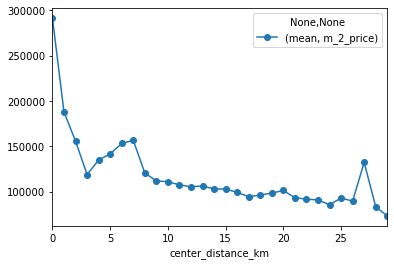

In [90]:
spb_pivot_data.plot(x='center_distance_km', 
                    y=[('mean', 'm_2_price')], 
                    kind='line',
                    marker = 'o')

plt.xlim([0, 29])

Центром можно считать область до 7 км включительно

Выделим сегмент квартир в центре. Проанализируем эту территорию и изучим следующие параметры: площадь, цена, число комнат, высота потолков. Также выделим факторы, которые влияют на стоимость квартиры (число комнат, этаж, удалённость от центра, дата размещения объявления). Сделааем выводы.

In [91]:
spb_center_data = spb_data[spb_data['center_distance_km']<=7]

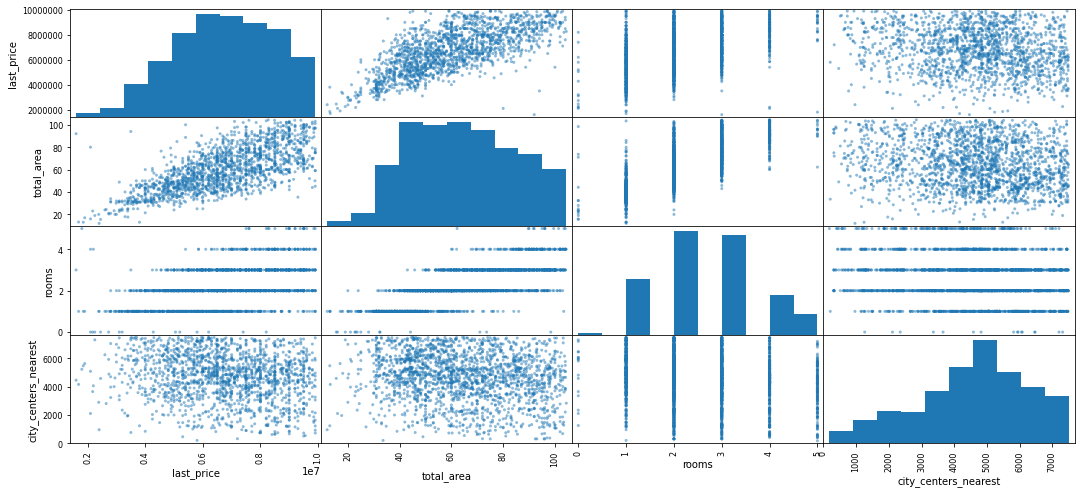

                      last_price  total_area     rooms  city_сenters_nearest
last_price              1.000000    0.693985  0.468945             -0.164904
total_area              0.693985    1.000000  0.746135             -0.162477
rooms                   0.468945    0.746135  1.000000             -0.173282
city_сenters_nearest   -0.164904   -0.162477 -0.173282              1.000000


In [92]:
pd.plotting.scatter_matrix(spb_center_data[['last_price', 'total_area', 'rooms', 'city_сenters_nearest']], figsize=(18, 8))
plt.show()
print(spb_center_data[['last_price', 'total_area', 'rooms', 'city_сenters_nearest']].corr())

Результаты не отличаются радикально от все выборки в целом. Разве что удаленность от центра уже совсем не имеет влияния на цену квартиры.

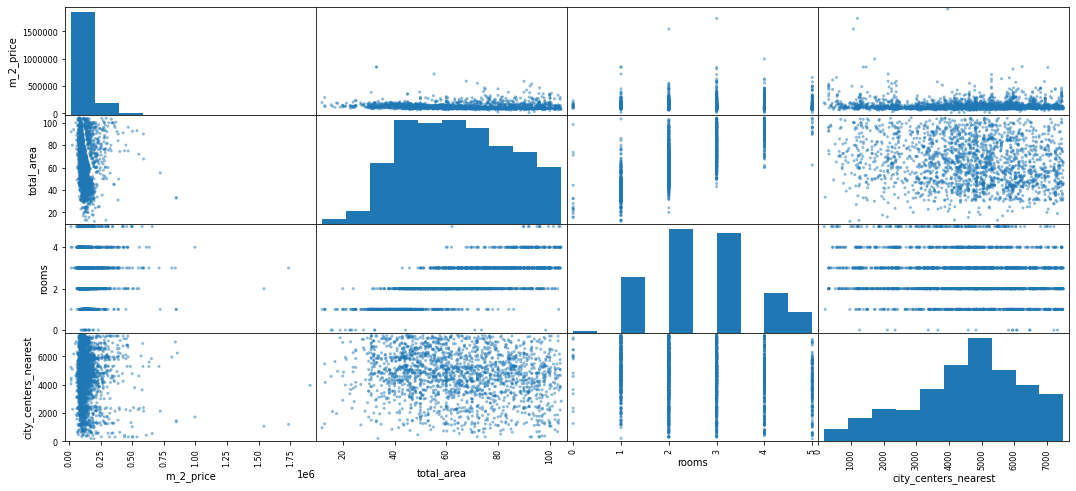

                      m_2_price  total_area     rooms  city_сenters_nearest
m_2_price              1.000000   -0.020236  0.014684             -0.029773
total_area            -0.020236    1.000000  0.746135             -0.162477
rooms                  0.014684    0.746135  1.000000             -0.173282
city_сenters_nearest  -0.029773   -0.162477 -0.173282              1.000000


In [93]:
pd.plotting.scatter_matrix(spb_center_data[['m_2_price', 'total_area', 'rooms', 'city_сenters_nearest']], figsize=(18, 8))
plt.show()
print(spb_center_data[['m_2_price', 'total_area', 'rooms', 'city_сenters_nearest']].corr())

Результаты для цены за кв. м не отличаются радикально от все выборки в целом. На цену квадратного метра еще перестает оказывать влияние количество комнат. Количество комнат сильно коррелирует с общей площадью, но при оценке цены квадратного метра этот фактор перестает иметь значение.

<AxesSubplot:xlabel='floor_category'>

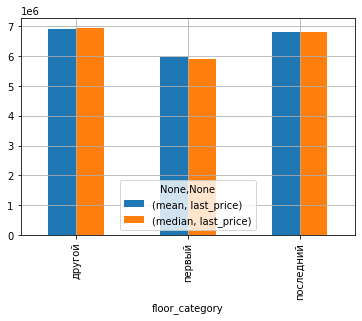

In [94]:
a = spb_center_data.pivot_table(index='floor_category', 
                            values='last_price', 
                            aggfunc= ['mean', 'median']).join(spb_center_data.pivot_table(index='floor_category', 
                                                                               values='m_2_price', 
                                                                               aggfunc= ['mean', 'median']))

a.plot(y = [('mean', 'last_price'), ('median', 'last_price')], kind='bar', grid= True)

<AxesSubplot:xlabel='floor_category'>

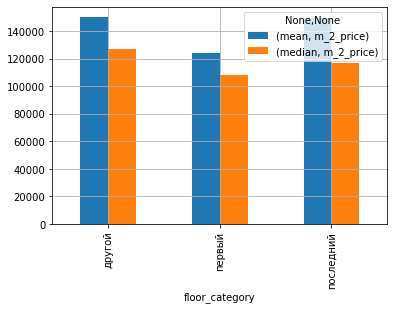

In [95]:
a.plot(y = [('mean', 'm_2_price'), ('median', 'm_2_price')], kind='bar', grid= True)

* Если смотреть на среднюю стоимость, то влияние этажа очевидно.
* Однако по медианному значению цены, аказывается, что любой другой этаж дороже последнего. Возможно это связано с тем, другой этаж - это слишком широкая категория. Возможна ситуация, кода другой этаж будет в одном добе выше, чем последний.

Аналогично и для цены за квадратный метр

<AxesSubplot:xlabel='weekday_exposition'>

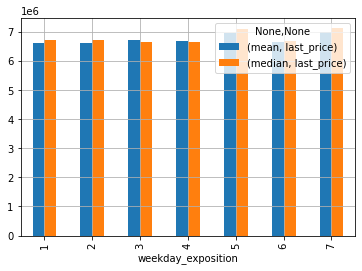

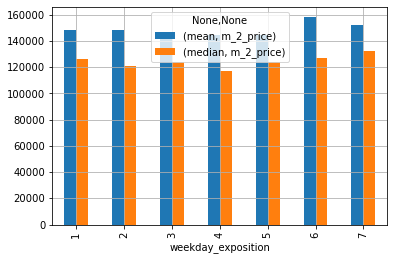

In [96]:
b = spb_center_data.pivot_table(index='weekday_exposition', 
                 values='last_price', 
                 aggfunc= ['mean', 'median']).join(spb_center_data.pivot_table(index='weekday_exposition', 
                                                                    values='m_2_price',
                                                                    aggfunc= ['mean', 'median']))

b.plot(y = [('mean', 'last_price'), ('median', 'last_price')], kind='bar', grid= True)
b.plot(y = [('mean', 'm_2_price'), ('median', 'm_2_price')], kind='bar', grid= True)

День недели, когда выставили квартиру на продажу, не оказывает никакого влияния на цену квартир и цену кв. м жилья.

<AxesSubplot:xlabel='month_exposition'>

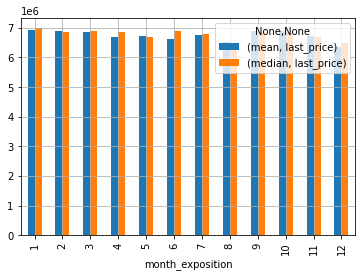

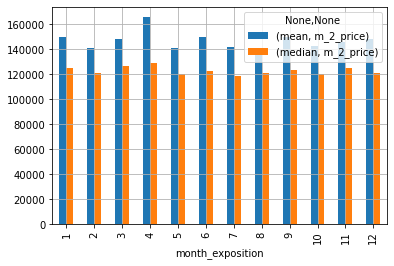

In [97]:
c = spb_center_data.pivot_table(index='month_exposition', 
                 values='last_price', 
                 aggfunc= ['mean', 'median']).join(spb_center_data.pivot_table(index='month_exposition', 
                                                                     values='m_2_price', 
                                                                     aggfunc= ['mean', 'median']))

c.plot(y = [('mean', 'last_price'), ('median', 'last_price')], kind='bar', grid= True)
c.plot(y = [('mean', 'm_2_price'), ('median', 'm_2_price')], kind='bar', grid= True)

Месяц, когда выставили квартиру на продажу, не оказывает никакого влияния на цену квартир и цену кв. м жилья.

<AxesSubplot:xlabel='year_exposition'>

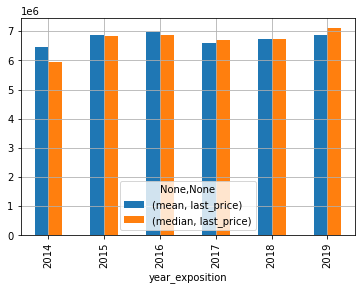

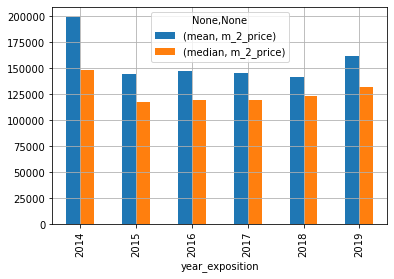

In [98]:
e = spb_center_data.pivot_table(index='year_exposition', 
                 values=['last_price', 'total_area'], 
                 aggfunc= ['count', 'mean', 'median']).join(spb_center_data.pivot_table(index='year_exposition', 
                                                                     values='m_2_price', 
                                                                     aggfunc= ['count', 'mean', 'median']))

e.plot(y = [('mean', 'last_price'), ('median', 'last_price')], kind='bar', grid= True)
e.plot(y = [('mean', 'm_2_price'), ('median', 'm_2_price')], kind='bar', grid= True)

Изначально если смотреть на среднюю стоимость квартиры, то мы получаем контринтуитивный вывод, что самая высокая цена была в самыом раннем году. Хотя если мы считаем, что цены даны в номинальном (не очищенном от инфляции) выражении, то стоило ожидать роста цены. Если добавить среднюю площадь, продаваемых квартир то окажется, что большая цена квартир в ранние годы объясняется, тем, что значительно снижалась средняя площадь квартир. За исключением 2014 г. средняя цена за кв. м жилья не сильно менялась.

# ВЫВОДЫ

* В рамках проекта была произведена обработка данных (заполнение пропусков,смена типов данных). Где было возможно заполнить пропуски, пропуски заполнялись медианными значениями, поскольку заполнение средними приводило бы к смещению результатов ввиду значительного смещения за счет выбросов с правой стороны. Для `living_area` пропуски были заполнены на основе того, что сильно коррелировал с `total_area`. Поэтому рассчитав среднюю долю жилой по имеющимся данным, можно заполнить пропуски путем умножения этой доли на общую площадь для наблюдений с пропусками

* В соответсвии с заданием было выявлено, что на стоимость квартиры в целом влияет в основном площадь квартиры и удаленность от центра. Однако степень этого влияния нельзя назвать сильной, покольку коэффициенты корреляции не достигали значений 0,8. Возможно существуют прочие ненаблюдаемые в данном ииследовании факторы, которые влияют на цену. Например, год постройки дома.

* На цену кв. м жилья можно наблюдать похожие результаты. Знаки коэффициентов корреляции совпадают с ожиданиями, но назвать связь сильной не представляется возможной.

* Было выявлено, что цена зависила от года, когда квартира выставлялась на продажу. Но это было связано с тем, что по годам отличалась и средняя площадь продаваемых квартир.

* Явных отличий во влиянии этих факторов на цены квартир в центре Санкт-Петербурга и по всей выборке в целом не выявлено.

* Было выявлено что 50% объявлений снимаются через 95 дней. Таким образом, быстрой можно считать продажу квартиры в более короткий срок. А долгой, наоборот, в более длинный период.